Tutorial - Part #5 - Image Coaddition
=====================

For image coaddition the package has a module called `operations`, which implements a main `coadd` function.

In [29]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline

In [30]:
from astropy.visualization import LinearStretch, LogStretch
from astropy.visualization import ZScaleInterval, MinMaxInterval
from astropy.visualization import ImageNormalize

In [32]:
palette = copy(plt.cm.gray)
palette.set_bad('r', 0.75)

In [33]:
import properimage.single_image as si
from properimage.operations import coadd

In [34]:
im1_path = './../../../data/aligned_eso085-030-004.fit'
im2_path = './../../../data/aligned_eso085-030-005.fit'

To get the subtraction we need to run this function by using both paths for example:

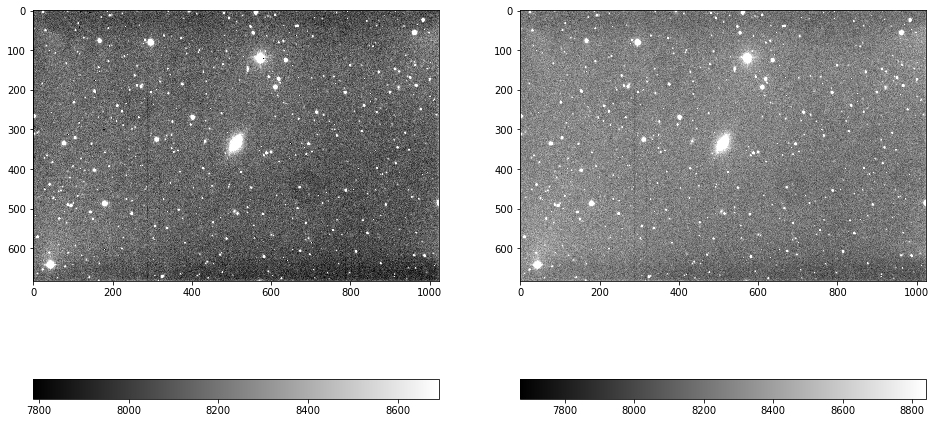

In [35]:
from astropy.io.fits import getdata

plt.figure(figsize=(16, 12))
plt.subplot(121)
ref = getdata(im1_path)
norm = ImageNormalize(ref, interval=ZScaleInterval(),
                      stretch=LinearStretch())

plt.imshow(ref, cmap=plt.cm.gray, norm=norm, interpolation='none')

plt.colorbar(orientation='horizontal')

plt.subplot(122)
ref = getdata(im2_path)
norm = ImageNormalize(ref, interval=ZScaleInterval(),
                      stretch=LinearStretch())

plt.imshow(ref, cmap=plt.cm.gray, norm=norm, interpolation='none')

plt.colorbar(orientation='horizontal')

In [36]:
R, P_r, mask = coadd(align=False, si_list=[im1_path, im2_path], inf_loss=0.25)

updating stamp shape to (21,21)
updating stamp shape to (21,21)


The result is a list of numpy arrays.

The arrays are in order: `R, P_r, mask`

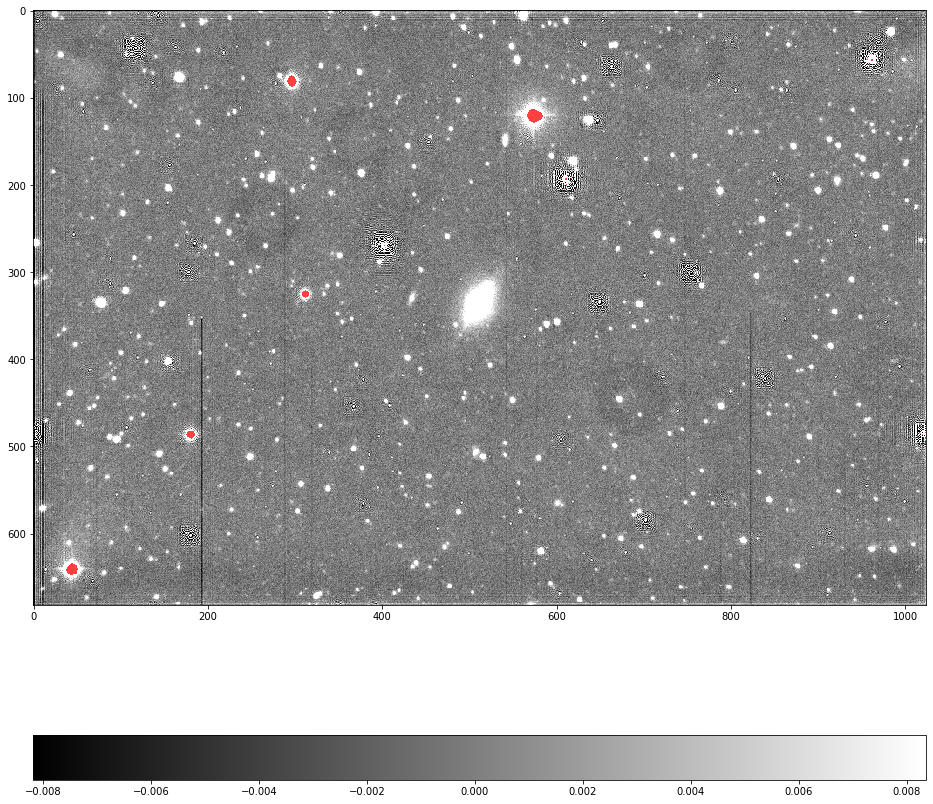

In [41]:
norm = ImageNormalize(R.real, interval=ZScaleInterval(),
                      stretch=LinearStretch())

plt.figure(figsize=(16, 16))
plt.imshow(np.ma.MaskedArray(R.real, mask=mask), 
           cmap=palette, norm=norm, interpolation='none')

plt.colorbar(orientation='horizontal')

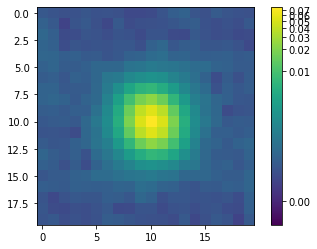

In [42]:
norm = ImageNormalize(P_r.real, interval=MinMaxInterval(),
                      stretch=LogStretch())
xc, yc = np.where(P_r.real==P_r.real.max())
xc, yc = np.round(xc[0]), np.round(yc[0])

plt.imshow(P_r.real[xc-10:xc+10, yc-10:yc+10], norm=norm,
           cmap='viridis', interpolation='none')
plt.colorbar()

In [43]:
R_1, P_r_1, mask_1 = coadd(align=False, si_list=[im1_path, im2_path], inf_loss=0.10)

updating stamp shape to (21,21)
updating stamp shape to (21,21)


The result is a list of numpy arrays.

The arrays are in order: `R, P_r, mask`

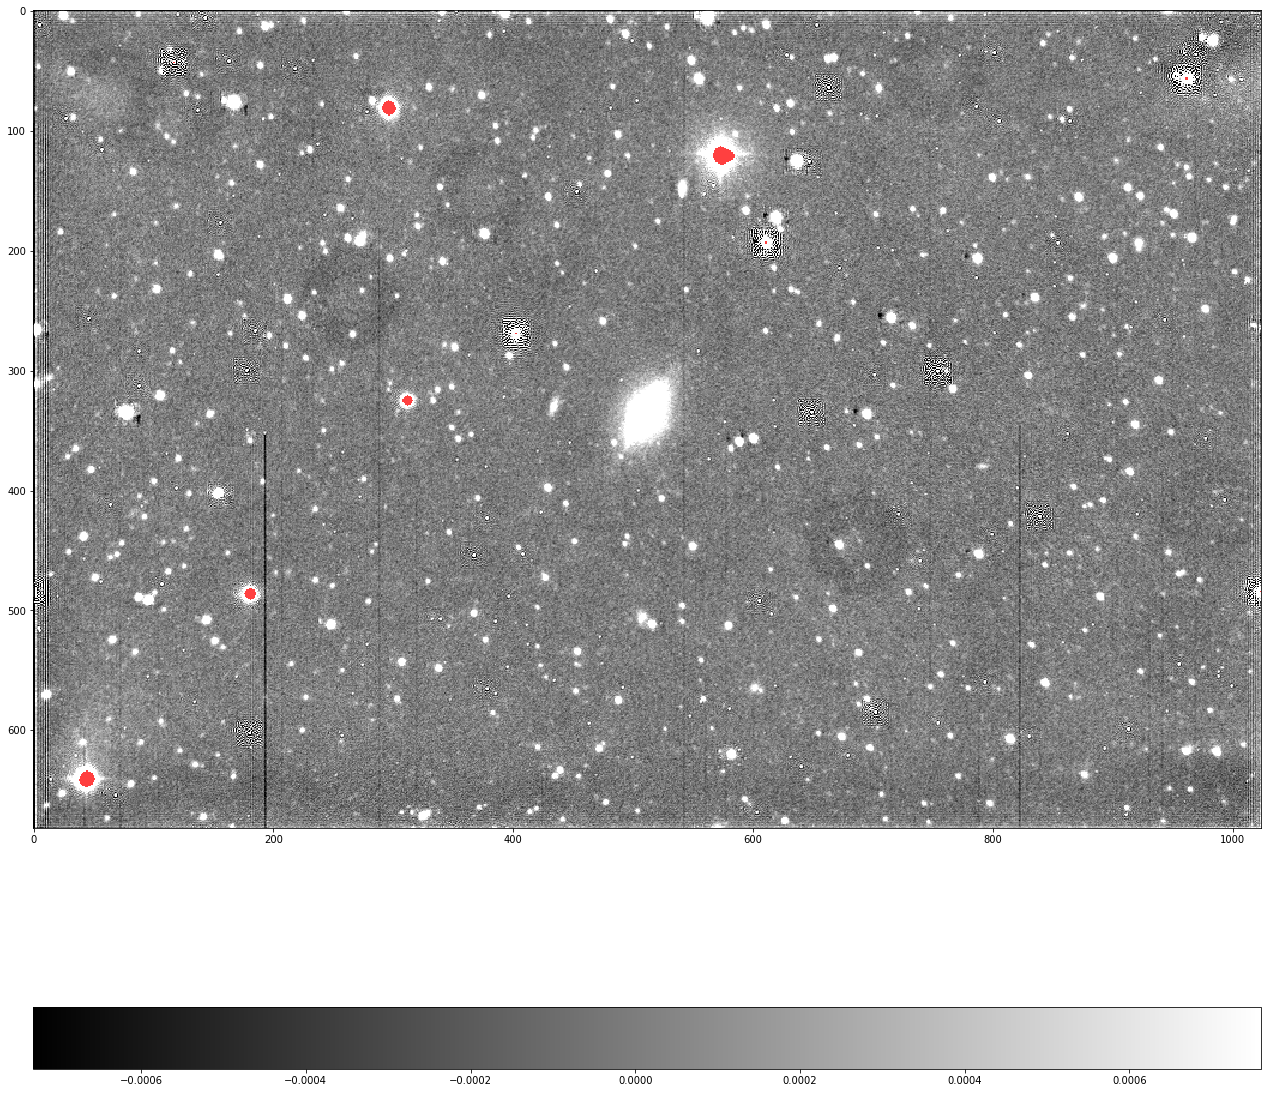

In [44]:
norm = ImageNormalize(R_1.real, interval=ZScaleInterval(),
                      stretch=LinearStretch())

plt.figure(figsize=(22, 22))
plt.imshow(np.ma.MaskedArray(R_1.real, mask=mask_1), 
           cmap=palette, norm=norm, interpolation='none')

plt.colorbar(orientation='horizontal')

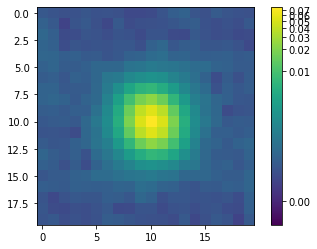

In [45]:
norm = ImageNormalize(P_r.real, interval=MinMaxInterval(),
                      stretch=LogStretch())
xc, yc = np.where(P_r.real==P_r.real.max())
xc, yc = np.round(xc[0]), np.round(yc[0])
plt.imshow(P_r.real[xc-10:xc+10, yc-10:yc+10], norm=norm,
           cmap='viridis', interpolation='none')
plt.colorbar()

Coadd using SWarp and compare photometry

In [27]:
import shlex, subprocess
cmd = 'swarp -IMAGEOUT_NAME coadd.fits -WEIGHT MAP_VARIANCE '+im1_path+' '+im2_path
cmd = shlex.split(cmd)
subprocess.call(cmd)

FileNotFoundError: [Errno 2] No such file or directory: 'swarp'

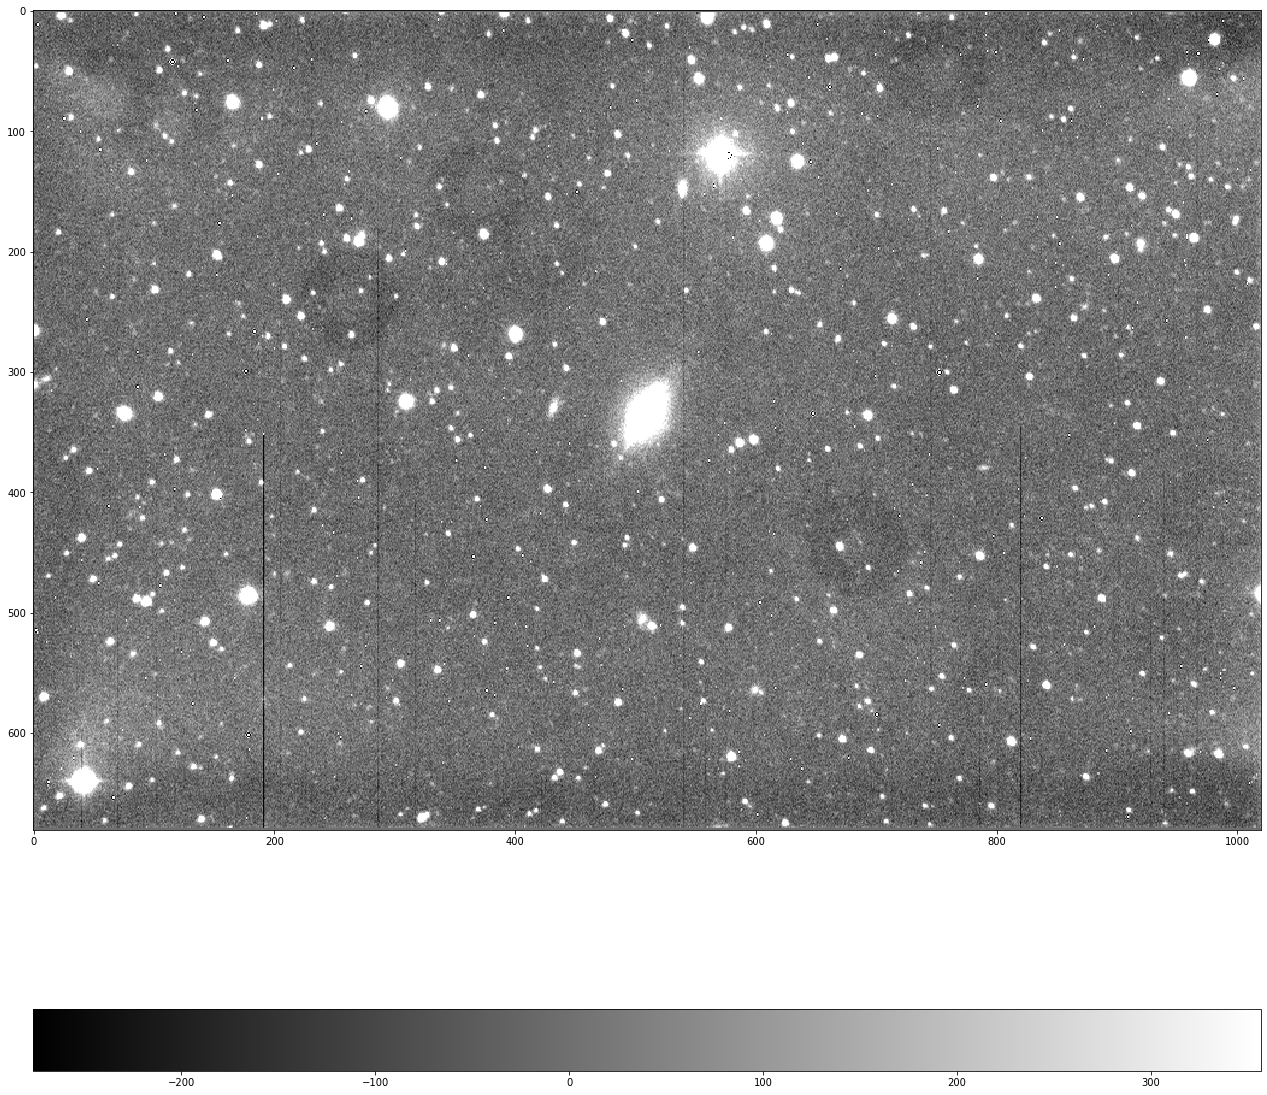

In [28]:
plt.figure(figsize=(22, 22))
coadd = getdata('coadd.fits')[18:-18, 28:-28]
norm = ImageNormalize(coadd, interval=ZScaleInterval(),
                      stretch=LinearStretch())

plt.imshow(coadd, cmap=plt.cm.gray, norm=norm, interpolation='none')

plt.colorbar(orientation='horizontal')

Detect sources on properimage's

In [131]:
import sep

In [132]:
xc, yc = np.where(P_r.real==P_r.real.max())
xc, yc = np.round(xc[0]), np.round(yc[0])
ker = P_r.real[xc-10:xc+10, yc-10:yc+10]

bkg_p = sep.Background(R.real.astype('<f4'), mask=mask)
srcs_p = sep.extract(R.real.astype('<f4')-bkg_p.back(), 1.5, 
                     err=bkg_p.globalrms, mask=mask)#, filter_kernel=ker)

In [133]:
len(srcs_p)

861

In [145]:
flux_p, fluxerr_p, flag_p = sep.sum_circle(R.real.astype('<f4')-bkg_p.back(), 
                                     srcs_p['x'], srcs_p['y'],
                                     5.0, err=bkg_p.globalrms, gain=1.0, bkgann=(8., 11.))

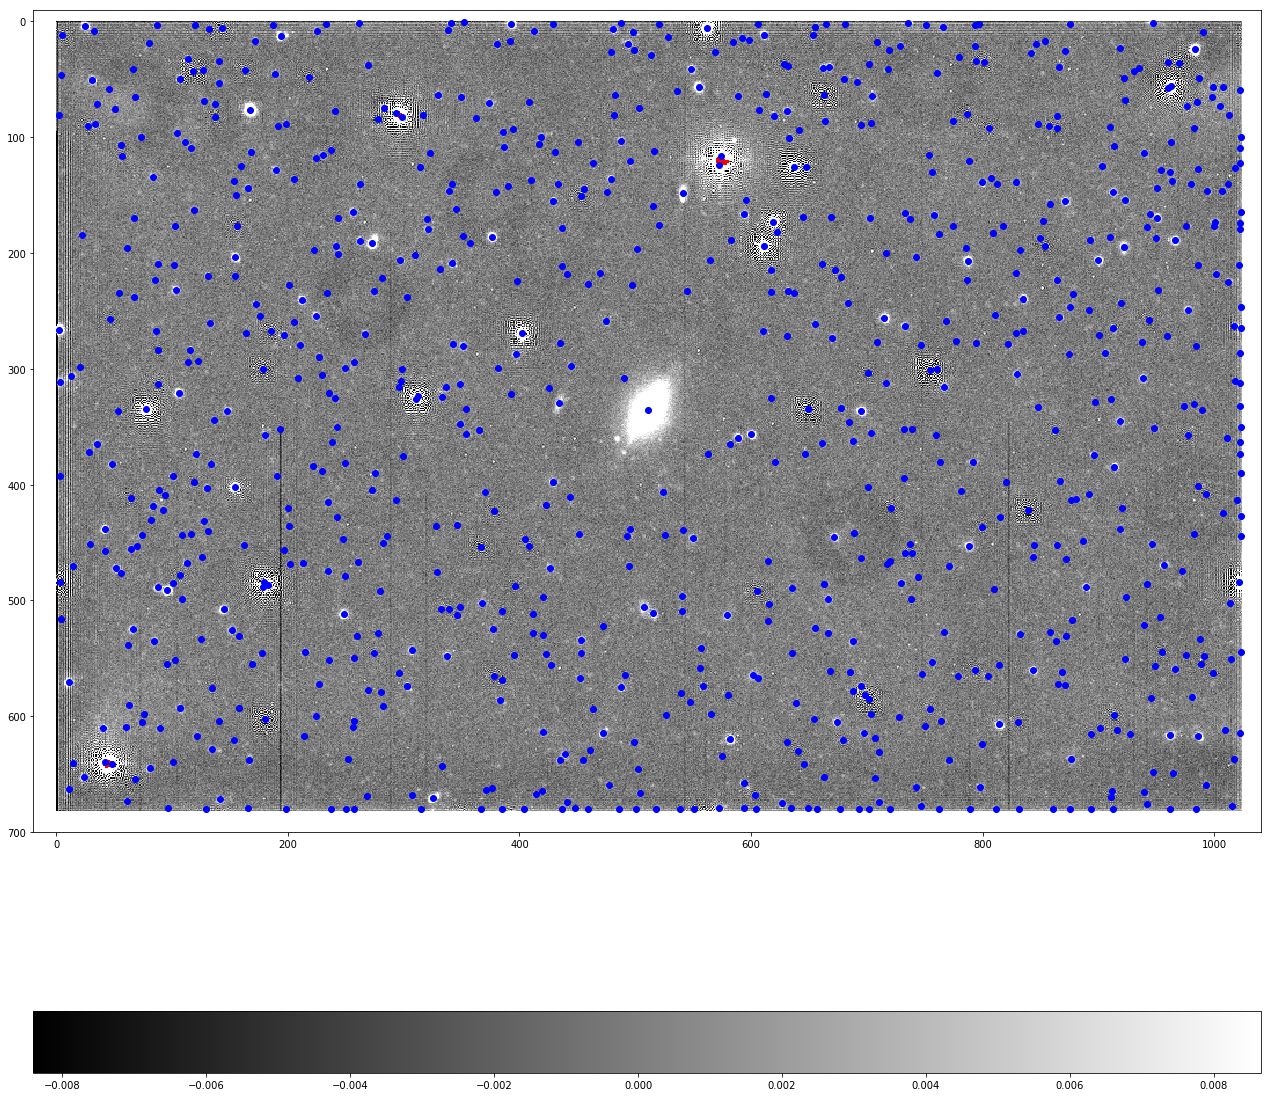

In [146]:
norm = ImageNormalize(R.real, interval=ZScaleInterval(),
                      stretch=LinearStretch())

plt.figure(figsize=(22, 22))
plt.imshow(np.ma.MaskedArray(R.real, mask=mask), 
           cmap=palette, norm=norm, interpolation='none')
plt.plot(srcs_p['x'], srcs_p['y'], 'bo')
plt.xlim(-20, 1040)
plt.ylim(700, -10)
plt.colorbar(orientation='horizontal')

In [147]:
bkg_c = sep.Background(coadd.astype('<f4'))
srcs_c = sep.extract(coadd.astype('<f4')-bkg_c.back(), 1.5, err=bkg_c.globalrms)

In [148]:
len(srcs_c)

949

In [149]:
flux, fluxerr, flag = sep.sum_circle(coadd.astype('<f4')-bkg_c.back(), 
                                     srcs_c['x'], srcs_c['y'],
                                     5.0, err=bkg_c.globalrms, gain=1.0, bkgann=(8., 11.))

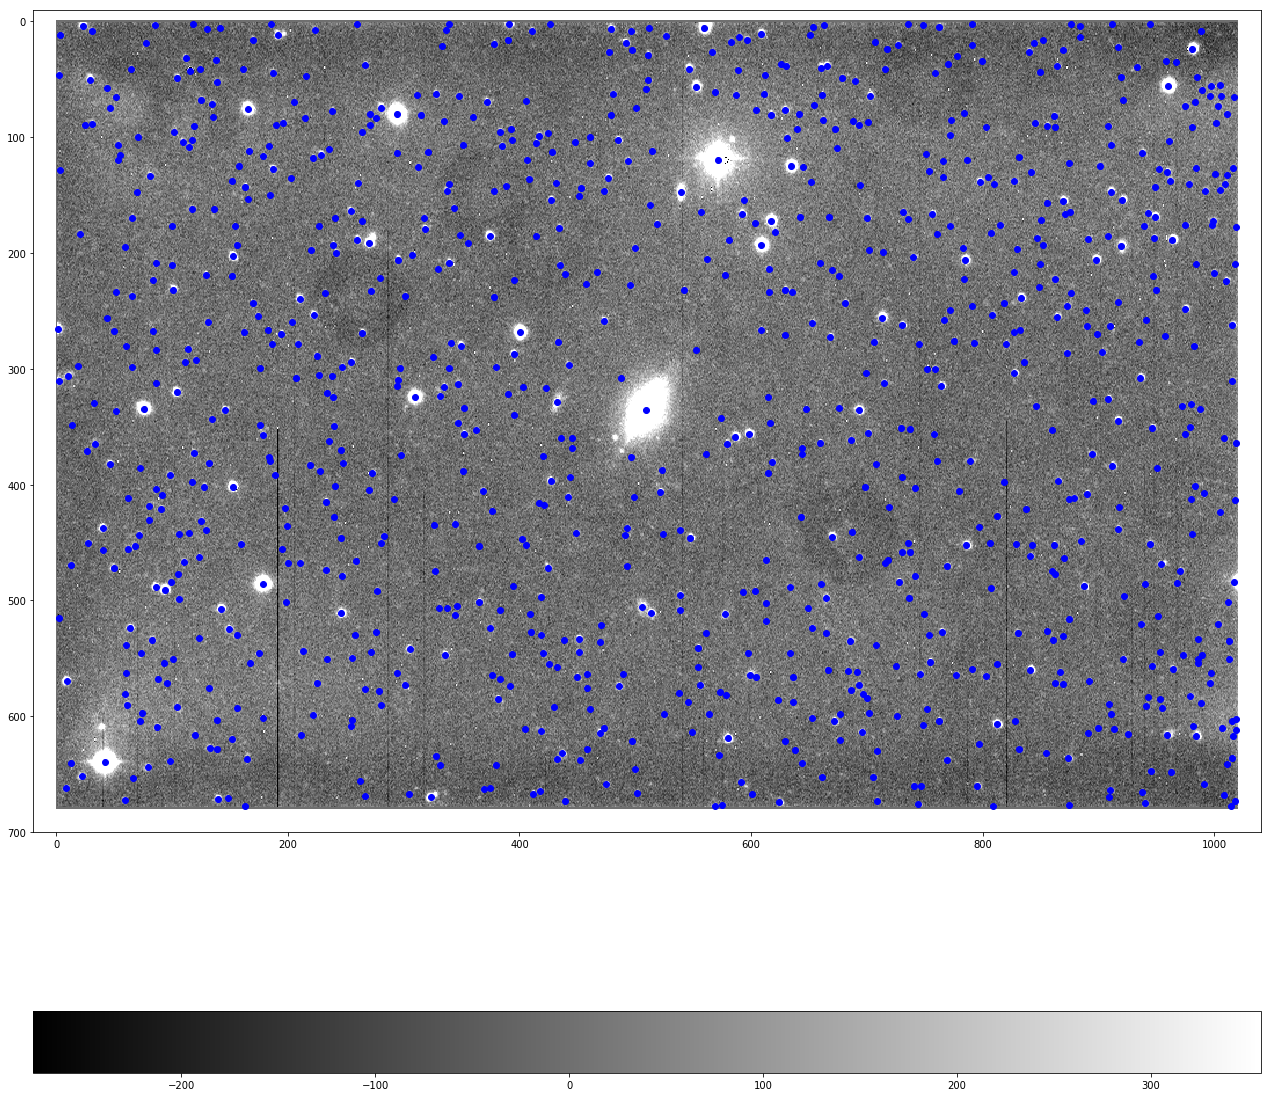

In [150]:
norm = ImageNormalize(coadd, interval=ZScaleInterval(),
                      stretch=LinearStretch())

plt.figure(figsize=(22, 22))
plt.imshow(coadd, cmap=palette, norm=norm, interpolation='none')
plt.plot(srcs_c['x'], srcs_c['y'], 'bo')
plt.xlim(-20, 1040)
plt.ylim(700, -10)
plt.colorbar(orientation='horizontal')

In [157]:
mag_p = -2.5*np.log10(flux_p)
mag_c = -2.5*np.log10(flux)

/home/bruno/.virtualenvs/iPTF/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/home/bruno/.virtualenvs/iPTF/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


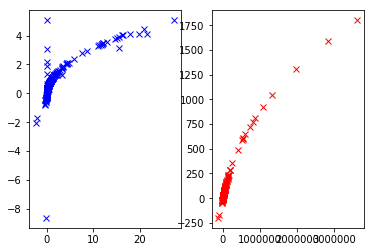

In [154]:
plt.subplot(121)
plt.plot(flux_p, flux_p/fluxerr_p, 'xb')
plt.subplot(122)
plt.plot(flux, flux/fluxerr, 'xr')

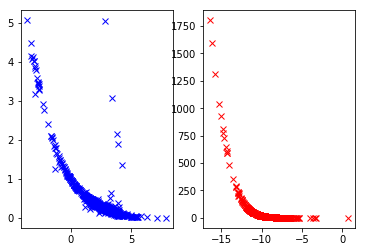

In [159]:
plt.subplot(121)
plt.plot(mag_p, flux_p/fluxerr_p, 'xb')
plt.subplot(122)
plt.plot(mag_c, flux/fluxerr, 'xr')

(array([  7.,  12.,  69., 249., 399., 128.,   8.,   4.,   0.,   1.]),
 array([-16.39415708, -14.67919319, -12.9642293 , -11.24926542,
         -9.53430153,  -7.81933765,  -6.10437376,  -4.38940987,
         -2.67444599,  -0.9594821 ,   0.75548179]),
 <a list of 10 Patch objects>)

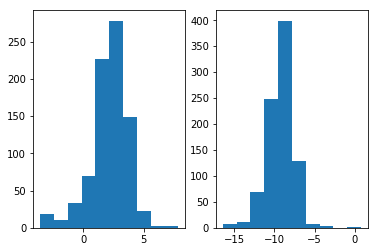

In [163]:
plt.subplot(121)
plt.hist(mag_p[~np.isnan(mag_p)])
plt.subplot(122)
plt.hist(mag_c[~np.isnan(mag_c)])